# Definitions

In [1]:
from dataclasses import dataclass, field
from typing import List

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from tqdm.notebook import tqdm

from validate import StatTest, Validator

# Data

In [2]:
url = 'https://docs.google.com/spreadsheets/d/1U7WJihimU4nSjv9QJR7mdj2eUvSY_iHVq0FiC_TlnSs/edit?usp=sharing'
sheet_id = url.split('/')[-2]
dwn_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

df = pd.read_csv(dwn_url, on_bad_lines='warn')
drop_cols = df.columns[df.columns.str.contains('Unnamed')]
df.drop(columns=drop_cols, inplace=True)
df.info(verbose=True, show_counts=True)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   user_id             10000 non-null  int64 
 1   created_date        10000 non-null  object
 2   age_group           10000 non-null  object
 3   install_date        10000 non-null  object
 4   channel             10000 non-null  object
 5   game_type           10000 non-null  object
 6   location            10000 non-null  object
 7   last_activity_date  10000 non-null  object
 8   cohort_age          10000 non-null  int64 
 9   group               10000 non-null  object
 10  converted           10000 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 859.5+ KB


,user_id,created_date,age_group,install_date,channel,game_type,location,last_activity_date,cohort_age,group,converted
0,0,2024-09-09 13:34:14,35-44,2024-09-03 13:34:14,Organic,Puzzle,Europe,2024-09-12 13:34:14,1,A,1
1,1,2024-08-27 13:34:14,18-24,2024-08-19 13:34:14,Ads,Action,Australia,2024-09-10 13:34:14,6,A,0
2,2,2024-08-18 13:34:14,25-34,2024-08-11 13:34:14,Email,Adventure,North America,2024-09-14 13:34:14,23,B,1
3,3,2024-09-01 13:34:14,25-34,2024-08-28 13:34:14,Email,Action,Europe,2024-09-08 13:34:14,16,B,1
4,4,2024-09-05 13:34:14,18-24,2024-08-28 13:34:14,Ads,Action,Asia,2024-09-12 13:34:14,25,B,1


# Validate Stat Criteria

In [3]:
validator = Validator(df)
validator

Validator(df=      user_id         created_date age_group         install_date  \
0           0  2024-09-09 13:34:14     35-44  2024-09-03 13:34:14   
1           1  2024-08-27 13:34:14     18-24  2024-08-19 13:34:14   
2           2  2024-08-18 13:34:14     25-34  2024-08-11 13:34:14   
3           3  2024-09-01 13:34:14     25-34  2024-08-28 13:34:14   
4           4  2024-09-05 13:34:14     18-24  2024-08-28 13:34:14   
...       ...                  ...       ...                  ...   
9995     9995  2024-09-14 13:34:14       45+  2024-09-11 13:34:14   
9996     9996  2024-09-13 13:34:14     35-44  2024-09-09 13:34:14   
9997     9997  2024-09-08 13:34:14     25-34  2024-09-02 13:34:14   
9998     9998  2024-09-05 13:34:14     18-24  2024-08-29 13:34:14   
9999     9999  2024-09-03 13:34:14     18-24  2024-08-29 13:34:14   

           channel  game_type       location   last_activity_date  cohort_age  \
0          Organic     Puzzle         Europe  2024-09-12 13:34:14           1

In [4]:
def get_report(test: StatTest, validator: Validator, bs_size=10_000):
    res, ks_pval, dist = validator.test_pvalue(test, bs_size=bs_size)
    min_size, pval_plot = validator.test_mde(test)
    print(f"P-Value test: {'passed' if res else 'failed'}, p-value: {ks_pval}")
    print(f"MDE test: min_size = {min_size}")
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].hist(dist, bins=20)
    axs[1].plot(pval_plot['x'], pval_plot['y'])

## T-Test

In [5]:
@dataclass(slots=True)
class TTest(StatTest):
    
    def __call__(self, a: pd.DataFrame, b: pd.DataFrame) -> float:
        return stats.ttest_ind(
            a[self.metric_column],
            b[self.metric_column],
        ).pvalue
    
ttest = TTest()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


P-Value test: passed, p-value: 0.1631628471838048
MDE test: min_size = 85


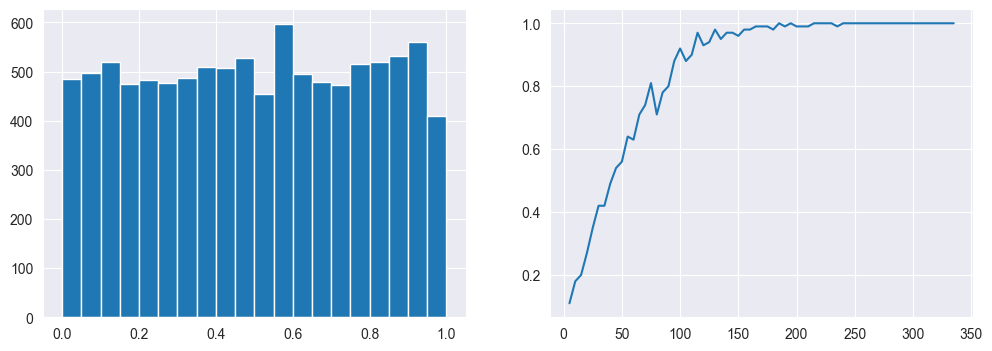

In [6]:
get_report(ttest, validator)

## KS-Test

In [7]:
@dataclass(slots=True)
class KSTest(StatTest):
    
    def __call__(self, a: pd.DataFrame, b: pd.DataFrame) -> float:
        return stats.ks_2samp(
            a[self.metric_column],
            b[self.metric_column],
        ).pvalue
    
kstest = KSTest()

  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_

  0%|          | 0/985 [00:00<?, ?it/s]

/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_play_case/.venv/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/Users/aapiskotin/projects/just_

P-Value test: failed, p-value: 0.0
MDE test: min_size = 135


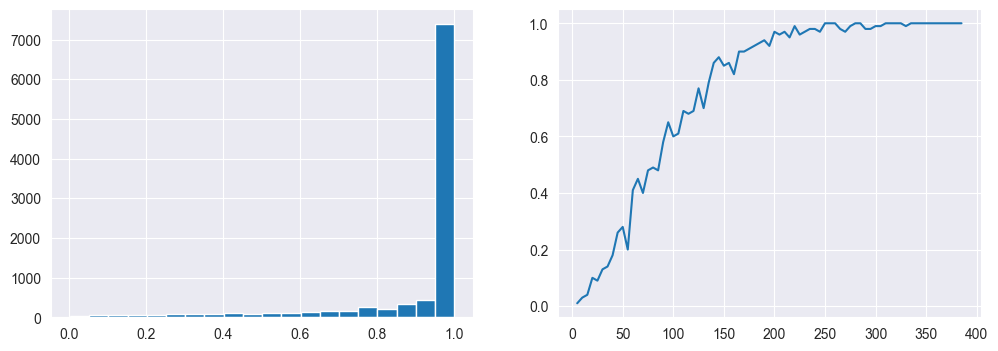

In [8]:
get_report(kstest, validator)

## Mann-Whitney U Test

In [9]:
@dataclass(slots=True)
class MannWhitneyU(StatTest):
    
    def __call__(self, a: pd.DataFrame, b: pd.DataFrame) -> float:
        return stats.mannwhitneyu(
            a[self.metric_column],
            b[self.metric_column],
        ).pvalue

In [10]:
mwu = MannWhitneyU()

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

P-Value test: passed, p-value: 0.14227009132888335
MDE test: min_size = 85


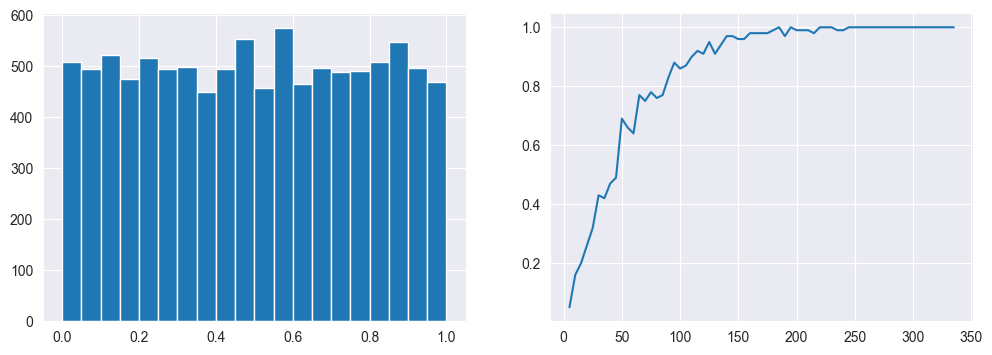

In [11]:
get_report(mwu, validator)

## Bootstrap

In [12]:
@dataclass(slots=True)
class Bootstrap(StatTest):
    bs_size: int = 1_000
    random_state: int = 648
    
    rng: np.random.Generator = np.random.default_rng(random_state)
    
    def __call__(self, a: pd.DataFrame, b: pd.DataFrame) -> float:
        # Compute the observed difference in means
        observed_diff = a[self.metric_column].mean() - b[self.metric_column].mean()
        
        # Combine data from both groups
        combined = np.concatenate([a[self.metric_column].values, b[self.metric_column].values])
        n_a = len(a)
        n_b = len(b)
        
        # Generate bootstrap samples under the null hypothesis
        resampled = self.rng.choice(combined, size=(self.bs_size, n_a + n_b), replace=True)
        a_bs = resampled[:, :n_a]
        b_bs = resampled[:, n_a:]
        
        # Compute the difference in means for each bootstrap sample
        diffs = a_bs.mean(axis=1) - b_bs.mean(axis=1)
        
        # Calculate the p-value for the two-sided test
        p_value = np.mean(np.abs(diffs) >= np.abs(observed_diff))
        return p_value
    
bs = Bootstrap()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

P-Value test: passed, p-value: 0.7616082847491794
MDE test: min_size = 75


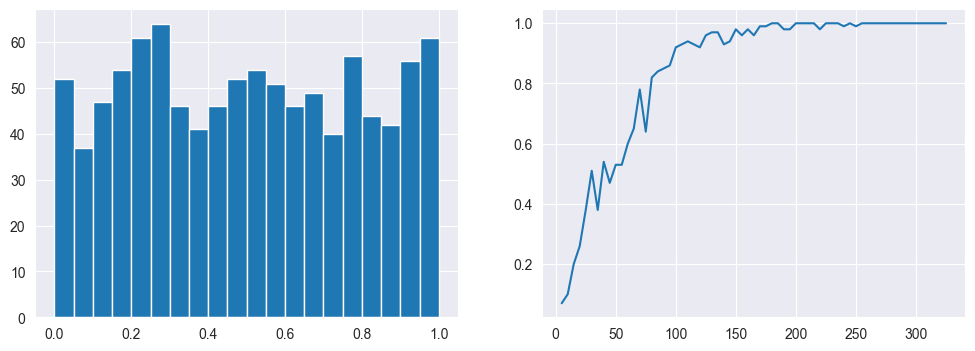

In [13]:
get_report(bs, validator, bs_size=1_000)

## StratifiedTTest 

In [14]:
@dataclass(slots=True)
class StratifiedTTest(StatTest):
    strat_columns: List[str] = field(kw_only=True)
    
    def __call__(self, a: pd.DataFrame, b: pd.DataFrame) -> float:
        a_strat = a.groupby(self.strat_columns).agg(
            count=(self.metric_column, 'count'),
            mean=(self.metric_column, 'mean'),
            std=(self.metric_column, 'std'),
        )
        a_strat['weight'] = a_strat['count'] / len(a)
        
        b_strat = b.groupby(self.strat_columns).agg(
            count=(self.metric_column, 'count'),
            mean=(self.metric_column, 'mean'),
            std=(self.metric_column, 'std'),
        )
        b_strat['weight'] = b_strat['count'] / len(b)
        
        # Align strata
        common_strata = a_strat.index.intersection(b_strat.index)
        a_strat = a_strat.loc[common_strata]
        b_strat = b_strat.loc[common_strata]
        
        # Calculate weighted means
        a_strat_mean = (a_strat['mean'] * a_strat['weight']).sum()
        b_strat_mean = (b_strat['mean'] * b_strat['weight']).sum()
        
        # Calculate variance of the weighted means
        a_strat_var = ( (a_strat['std'] ** 2) * (a_strat['weight'] ** 2) / a_strat['count'] ).sum()
        b_strat_var = ( (b_strat['std'] ** 2) * (b_strat['weight'] ** 2) / b_strat['count'] ).sum()
        
        # Compute t-statistic
        t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
        
        # Degrees of freedom
        df = min(len(a) - 1, len(b) - 1)
        
        # Compute two-tailed p-value
        return stats.t.sf(np.abs(t_stat), df) * 2
        
stt = StratifiedTTest(strat_columns=['location'])

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value enco

P-Value test: passed, p-value: 0.2906073769554326
MDE test: min_size = 80


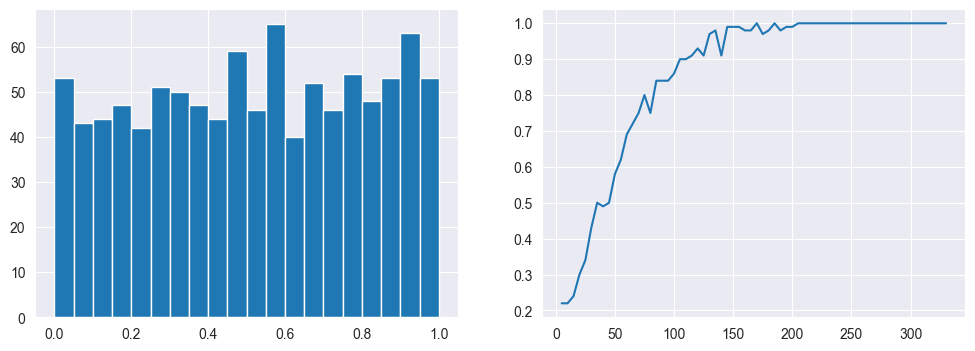

In [15]:
get_report(stt, validator, bs_size=1_000)

In [16]:
stratas = ['location', 'age_group', 'channel', 'game_type']
test_res = []
for i in tqdm(range(1, len(stratas)+1)):
    stt = StratifiedTTest(strat_columns=stratas[:i])
    pval_test, _, _ = validator.test_pvalue(stt, bs_size=1_000)
    min_sample_size, _ = validator.test_mde(stt)
    test_res.append((i, stratas[:i], pval_test, min_sample_size))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero enco

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encoun

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: divide by zero encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encoun

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/985 [00:00<?, ?it/s]

/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (a_strat_mean - b_strat_mean) / np.sqrt(a_strat_var + b_strat_var)
/var/folders/yd/p4t_h98570x7xvgn9smqb9xc0000gn/T/ipykernel_89133/2069388892.py:34: RuntimeWarning: invalid value encount

In [17]:
pd.DataFrame(
    test_res,
    columns=['n_stratas', 'stratas', 'pval_test', 'min_sample_size']
)

,n_stratas,stratas,pval_test,min_sample_size
0,1,[location],True,85
1,2,"[location, age_group]",True,75
2,3,"[location, age_group, channel]",True,100
3,4,"[location, age_group, channel, game_type]",True,130
